### Obtaining Testing and Training data

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

np.random.seed(42)
df = pd.read_csv("../train.csv")
df = df.drop("qid", axis=1)

In [2]:
df.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


## Vectorize Sentences

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["question_text"]
y = df["target"]

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_tfidf = vectorizer.fit_transform(X)

# Apply RandomUnderSampler to balance the classes
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_tfidf, y)

## Train and Validation split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, random_state=42, stratify=y_resampled)

X_test = pd.read_csv("../test.csv")
x_test = X_test["question_text"]

{0: np.float64(1.000008249872127), 1: np.float64(0.9999917502639916)}


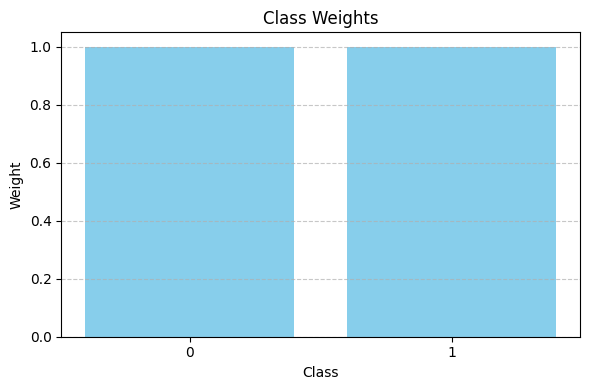

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classWeights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

classWeightDict = dict(enumerate(classWeights))
print(classWeightDict)
plt.figure(figsize=(6, 4))
plt.bar(classWeightDict.keys(), classWeightDict.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Weight')
plt.title('Class Weights')
plt.xticks(list(classWeightDict.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Definition

In [6]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42,
)

## Training

In [7]:
model.fit(X_train, y_train)

/Users/gavinrobey/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:25:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8309


## Confusion Matrix

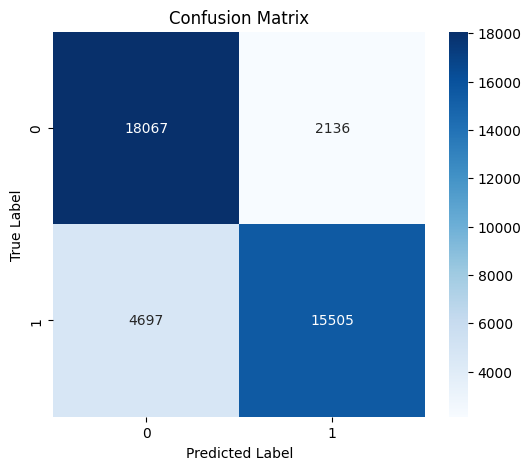

In [9]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## ROC Curve

ROC AUC Score: 0.9030


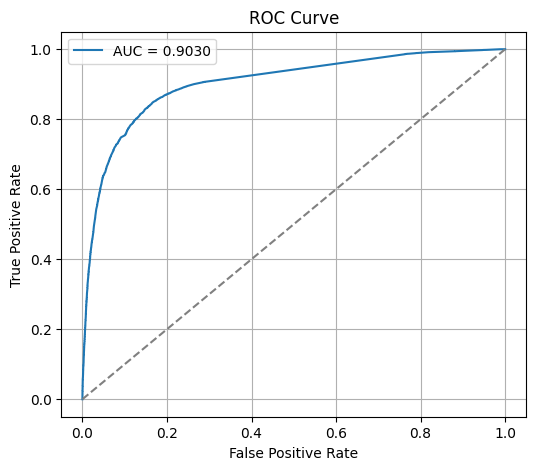

In [10]:
roc_auc = roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Submission

In [11]:
test_tfidf = vectorizer.fit_transform(x_test)

def submit():
    submission = X_test[['qid']].copy()
    prediction = model.predict_proba(test_tfidf)[:, 1]
    pred = (prediction > 0.5).astype(int)
    submission['prediction'] = pred
    submission.to_csv('submission.csv', index=False)
    return submission

submit()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0
